# Custom Supervisor Example

I want to make a version of an agent supervisor system that i have made, implementing the supervisor from scratch. 

This combines elements for the agent_supervisor, InjectedState and Reducers notebooks. See those for references.

We will implement an extremely simplified version of our RAG system, that will just load datasets into state and analize them. In order to do so we will have just a supervisor and a data analyst.

## 1. Create worker agent



In [2]:
# setup keys

import getpass
import os
from dotenv import load_dotenv

load_dotenv()

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("ANTHROPIC_API_KEY")

In [3]:
from langchain_core.tools import tool, InjectedToolCallId
from langchain_core.messages import ToolMessage
import os
from pathlib import Path
from langgraph.prebuilt import InjectedState
from typing import Union
from langchain_experimental.utilities import PythonREPL
from langgraph.types import Command

DATASET_FOLDER = "./LLM_data"

### 1.1 reducer and state schema

In [4]:
def merge_dictionary_entries(existing_dict: Union[dict, None] = None, new_dict: Union[dict, None] = None) -> dict:
    """
    Custom reducer to merge dictionary updates:
    adds keys from new_dict only if they are not already in existing_dict.
    """

    if not existing_dict:
        existing_dict = {}
    if not new_dict:
        new_dict = {}

    for key, data in new_dict.items():
        if key not in existing_dict:
            existing_dict[key] = data
    
    return existing_dict

In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from typing import Dict, Union
import pandas as pd
import geopandas as gpd
from langgraph.managed.is_last_step import RemainingSteps


class DatasetState(MessagesState):
    loaded: Annotated[Dict[str, Union[pd.DataFrame, gpd.GeoDataFrame]], merge_dictionary_entries] 
    remaining_steps: RemainingSteps  # this defaults to 25 and is automatically checked by LangGraph (see recursion_limits notebook)

### 1.2 Analyst

#### 1.2.1 Helper functions

In [6]:
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

#### 1.2.2 Tools



In [7]:
from langchain_core.tools import tool

# ----------------------
# Tool: list datasets
# ----------------------
@tool
def list_loadable_datasets() -> str:
    """Lists all available parquet datasets in the dataset folder."""
    files = [f for f in os.listdir(DATASET_FOLDER) if f.endswith(".parquet")]
    return "\n".join(files) if files else "No parquet datasets found."


# ----------------------
# Tool: python repl
# ----------------------
repl = PythonREPL()
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute"], 
    state: Annotated[DatasetState, InjectedState], 
    tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Use this to execute python code. If you want to see the output of a value,
    print it out with `print(...)`. This is visible to the user. 
    """

    for name, df in state["loaded"].items():
        repl.globals[name] = df
    
    try:
        result = repl.run(code)
    except BaseException as e:
        tool_err_1 = f"Failed to execute. Error: {repr(e)}"
        return Command(update={"messages": [ToolMessage(content=tool_err_1, tool_call_id=tool_call_id)]})
    
    tool_output = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return Command(update={"messages": [ToolMessage(content=tool_output, tool_call_id=tool_call_id)]})


# ----------------------
# Tool: load datasets
# ----------------------
@tool
def load_dataset(file_name: str, 
                 tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """
    Loads a Parquet dataset (optionally as GeoDataFrame) and updates state['loaded'][name].
    """
    update = {}

    file_stem = Path(file_name).stem
    file_name = f"{file_stem}.parquet"
    path = Path(DATASET_FOLDER) / file_name

    if not path.exists():
        available_files = os.listdir(DATASET_FOLDER)
        tool_err_result1 = f"File '{file_name}' not found. Available files: {available_files}"
        return Command(update={"messages": [ToolMessage(tool_err_result1, tool_call_id=tool_call_id)]})


    try:
        df = pd.read_parquet(path)
        if "geometry" in df.columns:
            try:
                df = gpd.read_parquet(path)
            except Exception as geo_err:
                tool_err_result2 = f"Geometry column found but failed to load as GeoDataFrame: {geo_err}"
                return Command(update={"messages": [ToolMessage(tool_err_result2, tool_call_id=tool_call_id)]})
            
        update[file_stem] = df

    except Exception as e:
        tool_err_result3 = f"Error loading dataset '{file_name}': {e}"
        return Command(update={"messages": [ToolMessage(tool_err_result3, tool_call_id=tool_call_id)]})


    return Command(update={
        "loaded": update,   
        "messages": [
            ToolMessage(f"Loaded dataset '{file_stem}' into memory.", tool_call_id=tool_call_id)
        ]
    })


#### 1.2.3 Create worker agent

In [8]:
analyst_suffix = (
    "You are a data analyst. Use your tools to explore and load datasets relevant to the task and analize them\n"
    "The files you need to load are in the subdirectory at ./LLM_data as .parquet files\n"
    "You can check which datasets are available to load using the `list_loadable_datasets` tool.\n"
    "You can write custom python code with your `python_repl_tool`\n"
    "**VERY IMPORTANT** : **When printing Python code, ALWAYS use `print(...)`**. Do NOT rely on implicit output like `quartieri.head()`. ALWAYS USE `print(...)`\n"
    "In your `python_repl_tool`, loaded datasets will appear as variables (e.g., if you load quartieri.parquet, the dataset will be accessible as `quartieri`)\n\n"
    "All spatial datasets use a geometry column (GeoDataFrame) containing shapely Point or Polygon objects.\n"
    "Always use the 'geometry' field when doing spatial operations, and avoid computing or reconstructing from latitude/longitude.\n"
    "When doing spatial queries (e.g., selecting features within 1 km), ensure you are working in a projected CRS (not WGS84). Use `.to_crs(epsg=32632)` to convert if needed.\n\n"
)

In [9]:
from langgraph.prebuilt import create_react_agent

analyst_agent = create_react_agent(
    model="anthropic:claude-sonnet-4-0",  
    tools=[list_loadable_datasets, 
           load_dataset, 
           python_repl_tool],
    prompt=analyst_suffix,
    name="analyst_agent",
    state_schema=DatasetState
)

## 2. Create Supervisor From Scratch

Now we want to create the supervisor agent by creating an agent with **handoff tools**. This will allow us to have more control on what information the supervisor hands to the worker agents, and what agents the supervisor can work with. 

Specifically, we will to ask the supervisor to **formulate a task explicitly** for the handoff. We can do so by passing a `task_description` parameter to our `handoff_tool` function, which the llm will populate at runtime.

------------

Error below: you did had not used DatasetState - don't know if it works with that fix right now

------------

In [ ]:
from typing import Annotated
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        state: Annotated[MessagesState, InjectedState],  # (!) mistake here, should be DatasetState
    ) -> Command:
        
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}     # pass state as input but replace messages with the task description to messages   
        return Command(
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_analyst_agent_with_description = create_task_description_handoff_tool(
    agent_name="analyst_agent",
    description="Assign task to a data analyst agent.",
)

In [11]:
# create the supervisor

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[assign_to_analyst_agent_with_description],
    prompt=(
        "You are a supervisor managing a data analyst agent. Assign data-analysis-related tasks to this assistant\n"
    ),
    name="supervisor",
    state_schema=DatasetState   # we are using a custom state schema
)

In [12]:
# create graph

supervisor_with_description = (
    StateGraph(DatasetState)
    .add_node(
        supervisor_agent_with_description, destinations=("analyst_agent", END)
    )
    .add_node(analyst_agent)
    .add_edge(START, "supervisor")
    .add_edge("analyst_agent", "supervisor")
    .compile()
)

>**Note:**
>
>We're using the [`Send()`](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Send) primitive in the `handoff_tool`. This means that instead of receiving the full `supervisor` graph state as input, each worker agent only sees the contents of the `Send` payload. In this example, we're sending the task description as a single "human" message.

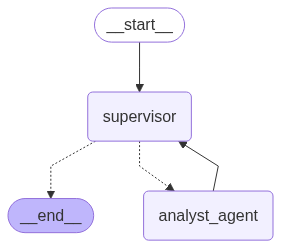

In [13]:
from IPython.display import display, Image

display(Image(supervisor_with_description.get_graph().draw_mermaid_png()))

## 3. Run the graph

In [14]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Load a dataset of your choice",
            }
        ]
    },
    subgraphs=True, # stream subgraphs as well (i.e., our worker agent)
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_analyst_agent (call_F73OS1ZqjF2xmQbhoNOmvVjD)
	 Call ID: call_F73OS1ZqjF2xmQbhoNOmvVjD
	  Args:
	    task_description: Load a dataset of your choice for data analysis, ensuring it is publicly available and suitable for demonstration purposes. Document the dataset's source, structure, and content.


Update from subgraph analyst_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: analyst_agent
	
	[{'text': "I'll start by checking what datasets are available in the data folder, then load one for analysis.", 'type': 'text'}, {'id': 'toolu_015vnxpyLgf12U7r6ga5QQMK', 'input': {}, 'name': 'list_loadable_datasets', 'type': 'tool_use'}]
	Tool Calls:
	  list_loadable_datasets (toolu_015vnxpyLgf12U7r6ga5QQMK)
	 Call ID: toolu_015vnxpyLgf1

Python REPL can execute arbitrary code. Use with caution.


Update from subgraph analyst_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: analyst_agent
	
	[{'text': 'Now let me examine the structure and content of this dataset:', 'type': 'text'}, {'id': 'toolu_01M3ZFNrLvsRGrgbJNn3TmRj', 'input': {'code': 'import pandas as pd\nimport geopandas as gpd\nimport numpy as np\n\n# Basic dataset information\nprint("=== NEIGHBORHOODS DATASET ANALYSIS ===")\nprint("\\n1. DATASET OVERVIEW")\nprint(f"Dataset type: {type(neighborhoods)}")\nprint(f"Shape: {neighborhoods.shape}")\nprint(f"Memory usage: {neighborhoods.memory_usage(deep=True).sum() / 1024**2:.2f} MB")'}, 'name': 'python_repl_tool', 'type': 'tool_use'}]
	Tool Calls:
	  python_repl_tool (toolu_01M3ZFNrLvsRGrgbJNn3TmRj)
	 Call ID: toolu_01M3ZFNrLvsRGrgbJNn3TmRj
	  Args:
	    code: import pandas as pd
	import geopandas as gpd
	import numpy as np
	
	# Basic dataset information
	print("=== NEIGHBORHOODS DATASET ANALYSIS ===")